# Failure modes of existing score matching methods

Code by Jacqueline Maasch | March 2024

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
from itertools import chain, combinations

# Machine learning imports.
from sklearn.preprocessing import StandardScaler

# Causal discovery imports.
import dodiscover
from dodiscover.metrics import toporder_divergence
import CausalDisco
from CausalDisco.analytics import (
    var_sortability,
    r2_sortability,
    snr_sortability,
    r2coeff,
    order_alignment
)
import networkx as nx

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


## Define functions

In [2]:
def plot_nx(adjacency_matrix,
            labels,
            figsize = (5,5),
            dpi = 75,
            node_size = 800,
            arrow_size = 10):

    '''
    Plot graph given adjacency matrix.
    '''
    
    g = nx.from_numpy_array(adjacency_matrix, create_using = nx.DiGraph)
    plt.figure(figsize = figsize, dpi = dpi)  
    nx.draw_circular(g, 
                     node_size = node_size, 
                     node_color = "pink",
                     labels = dict(zip(list(range(len(labels))), labels)), 
                     arrowsize = arrow_size,
                     with_labels = True)
    plt.show()
    plt.close()

In [3]:
def get_power_set(iterable):

    '''
    Get power set of an iterable (e.g., list, array). Returns chain oject.
    '''

    iterable = list(iterable)
    power_set = chain.from_iterable(combinations(iterable, i) \
                                    for i in range(len(iterable)+1))
    return power_set

In [4]:
def get_ci(results: list,
           z: float = 1.96,
           return_mean: bool = True) -> tuple:

    '''
    Get confidence interval. Default is 95% confidence interval.
    '''

    mean = np.mean(results)
    se = stats.sem(results)
    ci = [mean - (z * se), mean + (z * se)]
    if return_mean:
        return mean, ci
    return ci

## Generate data

,X0,X1,X2,X3,X4
0,1.270680,-0.320943,-1.103561,0.851451,0.916429
1,-0.695170,1.319320,-1.179465,1.027164,2.031123
2,-0.966752,-0.180459,0.394936,-0.122158,0.401202
3,0.776731,1.515047,-0.734373,-1.425396,-1.809107
4,-2.238560,1.452602,0.172228,0.415368,2.430168


,X0,X1,X2,X3,X4
0,0.823474,0.211395,0.026694,0.356746,-0.344126
1,1.240885,0.220635,0.093692,2.092904,2.220032
2,-0.633738,0.195130,0.456797,-0.443587,1.066288
3,0.454261,-0.081143,1.006896,0.144118,-0.273196
4,1.314685,0.024286,-0.608087,1.892725,2.214161


,X0,X1,X2,X3,X4
0,0.665716,-1.251394,-0.865587,-2.043230,-0.291380
1,-0.971807,-1.905139,-2.156748,-2.877028,-2.555281
2,-1.757620,1.040684,0.573491,-0.160520,-1.738466
3,0.148589,-0.552233,0.683557,0.058299,-1.700907
4,0.232084,-0.596170,0.564857,-1.269156,-2.306568


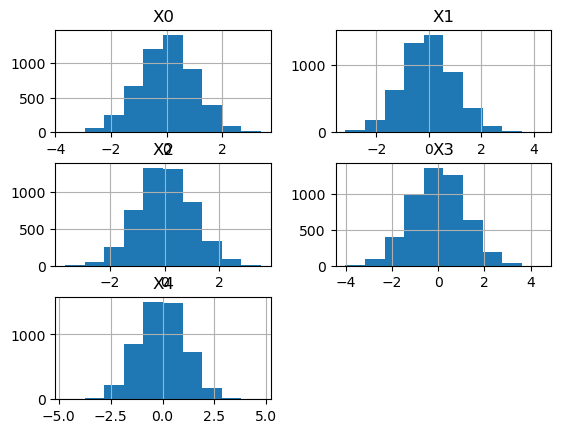

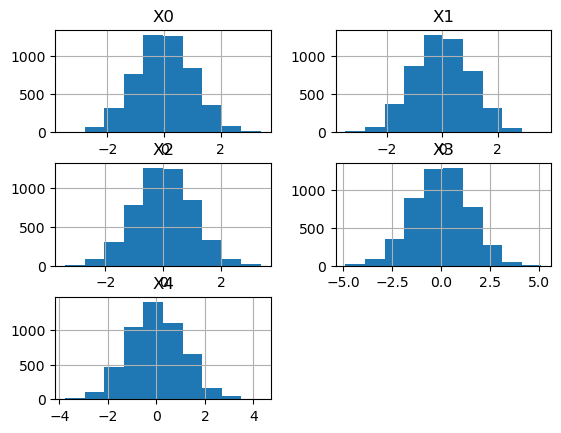

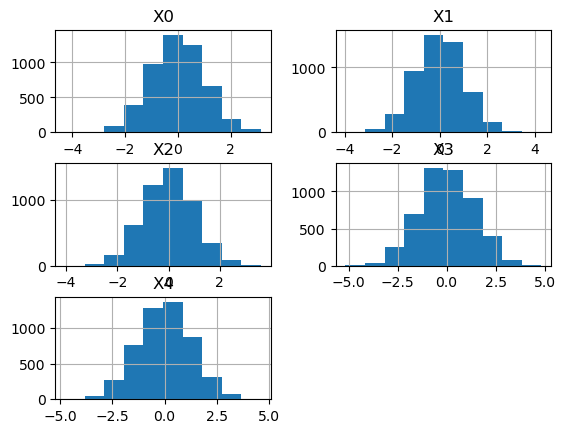

In [15]:
# Generate data.
n = 5000
degree = 1
coeff = lambda : np.random.uniform(low = 0.25, high = 0.65, size = 1)
noise = lambda x: np.random.normal(loc = 0.0, scale = 1.0, size = x)
replicates = 3
df_replicates = []

for i in range(replicates):
    X0 = noise(n)
    X1 = noise(n)
    X2 = noise(n)
    X3 = (coeff()*X0)**degree + (coeff()*X1)**degree + (coeff()*X2)**degree + noise(n)
    X4 = (coeff()*X3)**degree + noise(n)

    # dodiscover expects dataframes, and they are easy to look at.
    df = pd.DataFrame({"X0": X0, 
                       "X1": X1, 
                       "X2": X2, 
                       "X3": X3,
                       "X4": X4})
    if i < 3:
        display(df.head())
        df.hist()
    df_replicates.append(df)

In [16]:
# Generate adjacency matrix.
# Per networkx convention: entry i,j corresponds to an edge from i to j.
#       X0 X1 X2 X3 X4
adj = [[0, 0, 0, 1, 0], # X0
       [0, 0, 0, 1, 0], # X1
       [0, 0, 0, 1, 0], # X2
       [0, 0, 0, 0, 1], # X3
       [0, 0, 0, 0, 0]] # X4
adj = np.array(adj)

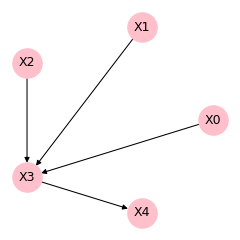

In [17]:
plot_nx(adj, 
        labels = df.columns,
        figsize = (3,3),
        dpi = 75)

## Topological sorts

[**Evaluation:**](https://www.pywhy.org/dodiscover/dev/generated/dodiscover.metrics.toporder_divergence.html) Topological order divergence = Sum of the number of edges of A not admitted by the given order.
>"Topological order divergence is used to compute the number of false negatives, i.e. missing edges, associated to a topological order of the nodes of a graph with respect to the ground truth structure. If the topological ordering is compatible with the graph ground truth, the divergence is equal to 0. In the worst case of completely reversed ordering, toporder_divergence is equals to P, the number of edges (positives) in the ground truth graph. Note that the divergence defines a lower bound for the Structural Hamming Distance."

**Note**: Because order divergence is a sum, we normalize this by P = the max possible divergence for the given ground truth graph (i.e., the number of true edges).

In [18]:
latents_power_set = list(get_power_set(["X0", "X1", "X2"]))
print(latents_power_set)

[(), ('X0',), ('X1',), ('X2',), ('X0', 'X1'), ('X0', 'X2'), ('X1', 'X2'), ('X0', 'X1', 'X2')]


In [20]:
# Sort replicates.
cols = ["X0", "X1", "X2", "X3", "X4"]
for latents in latents_power_set:

    times = []
    orders = []
    order_divergences = []

    print("\n--*-- Variables {} are latent. --*--\n".format(latents))
    
    for df in df_replicates:

        # Obscure variables.
        if len(latents) > 0:
            df = df.drop(columns = list(latents))
            adjacency = np.delete(adj, [cols.index(x) for x in latents], axis = 0)
            adjacency = np.delete(adjacency, [cols.index(x) for x in latents], axis = 1)
        else:
            adjacency = adj.copy()
        #print(adjacency)
    
        # Learn with DAS (SCORE). We only need the ordering, but this does the whole procedure.
        das = dodiscover.toporder.DAS()
        context = dodiscover.make_context().variables(data = df).build()
        start = time.time()
        das.learn_graph(df, context)
        times.append(time.time() - start)
    
        # Extract causal order.
        #print(das.order_)
        orders.append([df.columns[i] for i in das.order_])

        # Evaluate order quality.
        # Normalize divergence sum by total edges in ground truth (i.e., max divergence score).
        G = nx.from_numpy_array(adjacency, create_using = nx.DiGraph)
        relative_divergence = toporder_divergence(G, das.order_) / np.sum(adjacency)
        order_divergences.append(relative_divergence)

    # View performance.
    mean, ci = get_ci(times)
    print("Mean runtime : {} seconds ({}-{})".format(round(mean,3), 
                                                     round(ci[0],3), 
                                                     round(ci[1],3)))
    mean, ci = get_ci(order_divergences)
    print("Mean relative order divergence : {} ({}-{})".format(round(mean,3), 
                                                               round(ci[0],3), 
                                                               round(ci[1],3)))
    print("\nCausal orderings :", orders)


--*-- Variables () are latent. --*--

Mean runtime : 30.657 seconds (30.378-30.936)
Mean relative order divergence : 0.167 (-0.16-0.493)

Causal orderings : [['X1', 'X0', 'X4', 'X3', 'X2'], ['X1', 'X0', 'X2', 'X3', 'X4'], ['X0', 'X2', 'X1', 'X3', 'X4']]

--*-- Variables ('X0',) are latent. --*--

Mean runtime : 24.533 seconds (24.198-24.868)
Mean relative order divergence : 0.222 (0.004-0.44)

Causal orderings : [['X1', 'X3', 'X4', 'X2'], ['X1', 'X2', 'X4', 'X3'], ['X1', 'X2', 'X3', 'X4']]

--*-- Variables ('X1',) are latent. --*--

Mean runtime : 24.086 seconds (24.021-24.151)
Mean relative order divergence : 0.333 (-0.044-0.711)

Causal orderings : [['X3', 'X4', 'X0', 'X2'], ['X0', 'X2', 'X4', 'X3'], ['X0', 'X2', 'X3', 'X4']]

--*-- Variables ('X2',) are latent. --*--

Mean runtime : 24.46 seconds (24.162-24.757)
Mean relative order divergence : 0.222 (0.004-0.44)

Causal orderings : [['X1', 'X0', 'X4', 'X3'], ['X1', 'X0', 'X4', 'X3'], ['X0', 'X1', 'X3', 'X4']]

--*-- Variables ('X0

## End of document